Neural style tansfer using l-bfgs optimizer
- Method described in [Gatys, L. A., Ecker, A. S., & Bethge, M. (2015). A neural algorithm of artistic style. arXiv preprint arXiv:1508.06576.](https://arxiv.org/pdf/1508.06576.pdf)
- Code inspired by [this](https://github.com/titu1994/Neural-Style-Transfer) l-bfgs optimizer support of [keras](https://keras.io/examples/generative/neural_style_transfer/) base neural style transfer code.
- Use google Colab's GPU, otherwise it will be slow.


In [1]:
#!/usr/bin/env python

import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.applications import vgg19
from scipy.optimize import fmin_l_bfgs_b
from keras import backend as K
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, AveragePooling2D, MaxPooling2D
from keras.models import Model

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:




# base_image_path = keras.utils.get_file("paris.jpg", "https://i.imgur.com/F28w3Ac.jpg")
base_image_path = keras.utils.get_file("street.jpg", "https://cdn.vox-cdn.com/thumbor/bQzTI1QiGVU5cNjNatkzBWSQtEc=/1400x1050/filters:format(jpeg)/cdn.vox-cdn.com/uploads/chorus_asset/file/19909387/200408_12_40_44__7R42999.jpg")
# base_image_path = keras.utils.get_file("germany.jpg", "https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg")
# base_image_path = keras.utils.get_file("landscape.jpg", "https://media.istockphoto.com/photos/mountain-landscape-picture-id517188688?b=1&k=20&m=517188688&s=612x612&w=0&h=x8h70-SXuizg3dcqN4oVe9idppdt8FUVeBFemfaMU7w=")

# style_reference_image_path = keras.utils.get_file(
#     "starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg"
# )
# style_reference_image_path = keras.utils.get_file(
#     "cartoon_landscape.jpg", "https://mir-s3-cdn-cf.behance.net/project_modules/max_1200/26995949109231.58ab6d0e2048a.jpg"
# )
# style_reference_image_path = keras.utils.get_file(
#     "anime_house.jpg", "https://s3.voyapon.com/wp-content/uploads/sites/2/2021/07/18211705/32-1024x576.png"
# )
# style_reference_image_path = keras.utils.get_file(
#     "cartoon_house.jpg", "https://img.playbuzz.com/image/upload/ar_1.5,c_crop/q_auto:good,f_auto,fl_lossy,w_640,c_limit,dpr_2.5/v1594739056/jpq0svhejx6zoplpva4a.png"
# )
style_reference_image_path = keras.utils.get_file(
    "your_name_night.jpg", "https://i.f1g.fr/media/cms/orig/2020/05/13/165abe343138e27ea18e2b9380ef9c3724d7cb00dd670b6e439926c056ed2ba4.jpeg"
)
# style_reference_image_path = keras.utils.get_file(
#     "miyazaki_green.jpg", "http://images6.fanpop.com/image/photos/40100000/Howl-s-Moving-Castle-Scenery-hayao-miyazaki-40143092-1280-705.jpg"
# )
# style_reference_image_path = keras.utils.get_file(
#     "anime_street.jpg", "https://i.pinimg.com/originals/a9/8e/d4/a98ed4235d69f0ddc3d60fd9f6f8a0ef.jpg"
# )
# style_reference_image_path = keras.utils.get_file(
#     "ship_painting.jpg", "https://upload.wikimedia.org/wikipedia/commons/2/2e/Shipwreck_turner.jpg"
# )
# style_reference_image_path = keras.utils.get_file(
#     "city_painting.jpg", "https://afremov.com/images/product/misty-city.jpeg"
# )


result_prefix = "img_generated"

# Weights of the different loss components
# total_variation_weight = 1e-6
# style_weight = 1e-5
# content_weight = 1e-8
total_variation_weight = 8.5E-5
style_weight = 1
content_weight = 0.001

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 300
img_ncols = int(width * img_nrows / height)

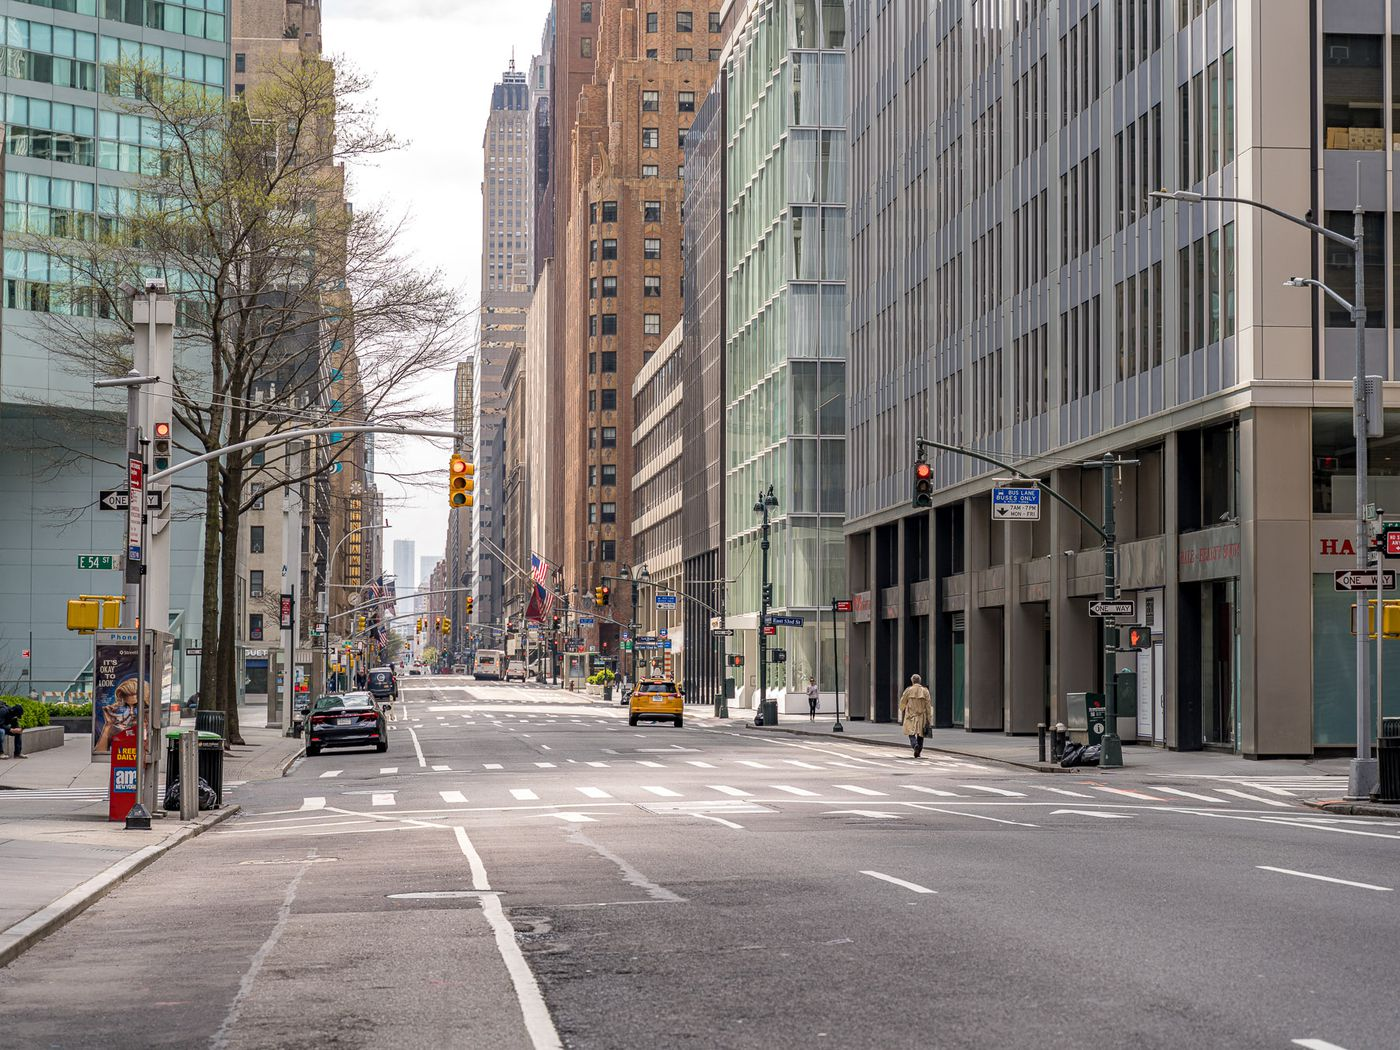

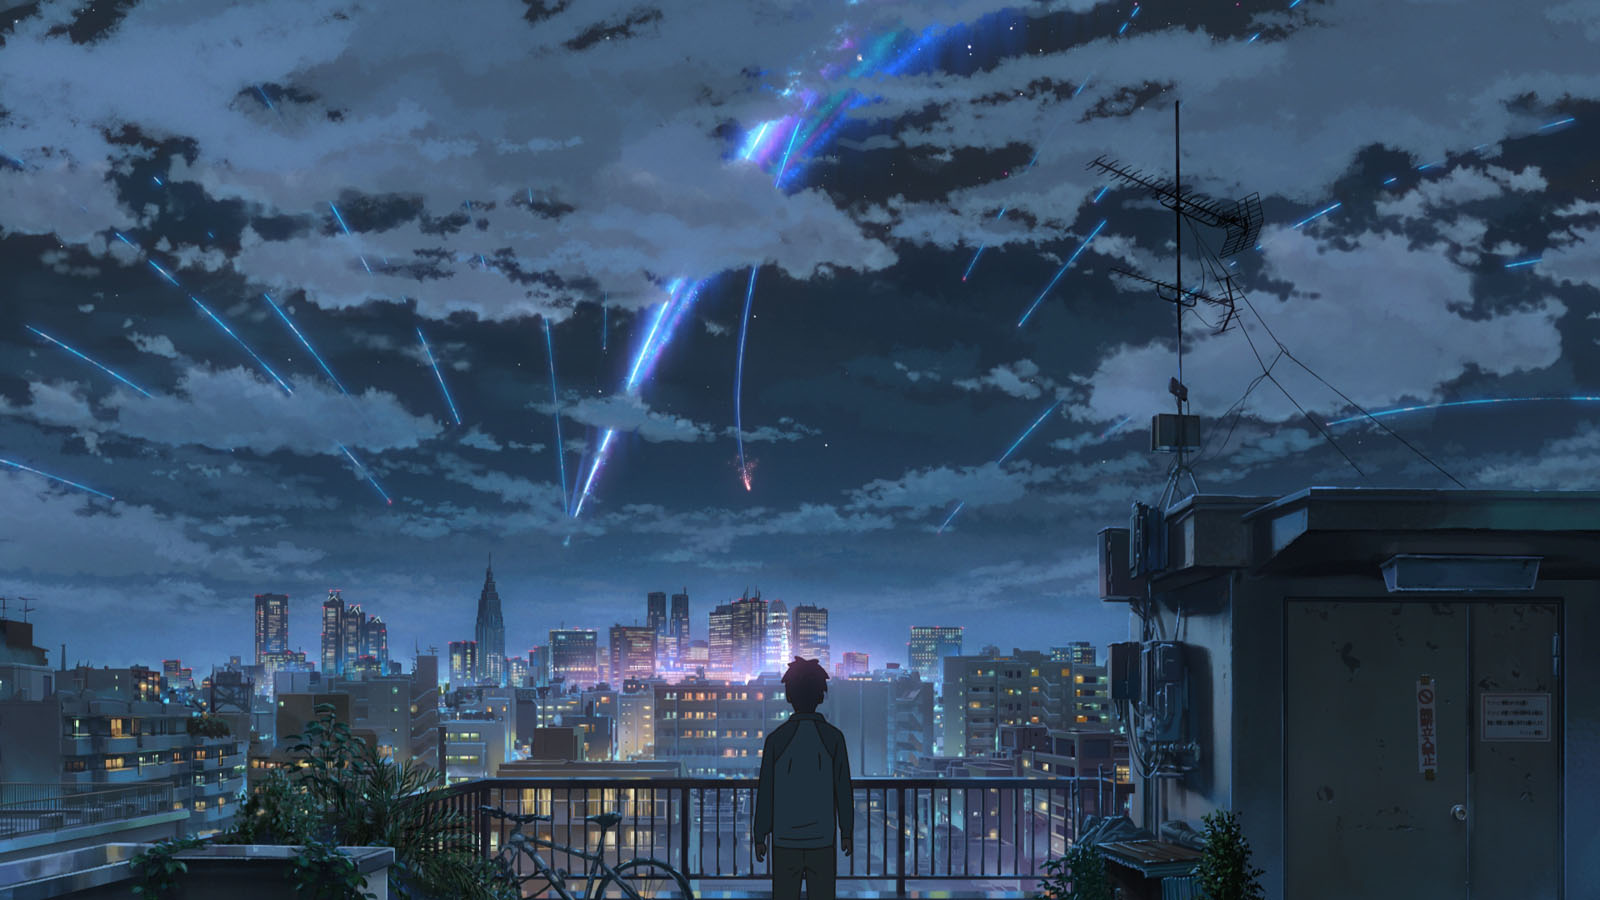

In [ ]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

In [ ]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)

    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img
    # return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x



# The gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    # x = tf.transpose(x, (2, 0, 1))
    # features = tf.reshape(x, (tf.shape(x)[0], -1))
    # gram = tf.matmul(features, tf.transpose(features))

    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

Load vgg19 model with our tensor as input

In [ ]:
tf.compat.v1.disable_eager_execution()

base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

image_tensors = [base_image]
image_tensors.append(style_reference_image)
image_tensors.append(combination_image)
nb_tensors = len(image_tensors)

input_tensor = K.concatenate(image_tensors, axis=0)

shape = (nb_tensors, img_nrows, img_ncols, 3)
print(shape)
ip = Input(tensor=input_tensor, batch_shape=shape)

model = vgg19.VGG19(weights="imagenet", include_top=False, pooling="avg", input_tensor=ip, input_shape=shape[1:])

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
shape_dict = dict([(layer.name, layer.output_shape) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


loss = K.variable(0.)
print(outputs_dict)
layer_features = outputs_dict["block5_conv2"]  # 'conv5_2' or 'conv4_2'
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[nb_tensors - 1, :, :, :]
loss = loss + content_weight * content_loss(base_image_features, combination_features)


style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]


for layer_name in style_layer_names:
  layer_features = outputs_dict[layer_name]
  shape = shape_dict[layer_name]
  combination_features = layer_features[nb_tensors-1, :, :, :]

  style_reference_features = layer_features[1:nb_tensors - 1, :, :, :]
  print(style_reference_features)
  sl = []
  sl.append(style_loss(style_reference_features[0], combination_features))
  loss = loss + (1 / len(style_layer_names)) * sl[0]


loss = loss + total_variation_weight * total_variation_loss(combination_image)

# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

outputs = [loss]
if type(grads) in {list, tuple}:
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)


def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

(3, 300, 400, 3)
{'input_23': <tf.Tensor 'concat_22:0' shape=(3, 300, 400, 3) dtype=float32>, 'block1_conv1': <tf.Tensor 'block1_conv1_22/Relu:0' shape=(3, 300, 400, 64) dtype=float32>, 'block1_conv2': <tf.Tensor 'block1_conv2_22/Relu:0' shape=(3, 300, 400, 64) dtype=float32>, 'block1_pool': <tf.Tensor 'block1_pool_22/MaxPool:0' shape=(3, 150, 200, 64) dtype=float32>, 'block2_conv1': <tf.Tensor 'block2_conv1_22/Relu:0' shape=(3, 150, 200, 128) dtype=float32>, 'block2_conv2': <tf.Tensor 'block2_conv2_22/Relu:0' shape=(3, 150, 200, 128) dtype=float32>, 'block2_pool': <tf.Tensor 'block2_pool_22/MaxPool:0' shape=(3, 75, 100, 128) dtype=float32>, 'block3_conv1': <tf.Tensor 'block3_conv1_22/Relu:0' shape=(3, 75, 100, 256) dtype=float32>, 'block3_conv2': <tf.Tensor 'block3_conv2_22/Relu:0' shape=(3, 75, 100, 256) dtype=float32>, 'block3_conv3': <tf.Tensor 'block3_conv3_22/Relu:0' shape=(3, 75, 100, 256) dtype=float32>, 'block3_conv4': <tf.Tensor 'block3_conv4_22/Relu:0' shape=(3, 75, 100, 256

In [ ]:
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values


evaluator = Evaluator()

In [ ]:
# x = np.random.uniform(0, 255, (1, img_nrows, img_ncols, 3)) - 128. # start from noise
x = preprocess_image(base_image_path) # start from base content image
num_iter = 100
prev_min_val = -1

for i in range(num_iter):
    print("Starting iteration %d of %d" % ((i + 1), num_iter))

    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)

    if prev_min_val == -1:
        prev_min_val = min_val

    improvement = (prev_min_val - min_val) / prev_min_val * 100

    print('Current loss value:', min_val, " Improvement : %0.3f" % improvement, "%")
    prev_min_val = min_val
    # save current generated image
    img = deprocess_image(x.copy())

    fname = result_prefix + '_at_iteration_%d.png' % (i)
    keras.preprocessing.image.save_img(fname, img)
    display(Image(result_prefix + '_at_iteration_%d.png' % i))


Output hidden; open in https://colab.research.google.com to view.